<a href="https://colab.research.google.com/github/selina-lii/Sut3_plot3/blob/main/Copy_of_eecs598_hw2_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Question Answering on Squad
## EECS 498/598 Winter 2024

Homework Submission Due: Friday, Feburary 23, 11:59pm
Please submit both pdf and ipynb files of this note book on Gradescope and make sure your code can be run without bugs. If you are working this on Google Colab, please be careful with your GPU usage limit.

# Overview
---
In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For this assignment, the task is finetuning a BERT-like model on the dataset.

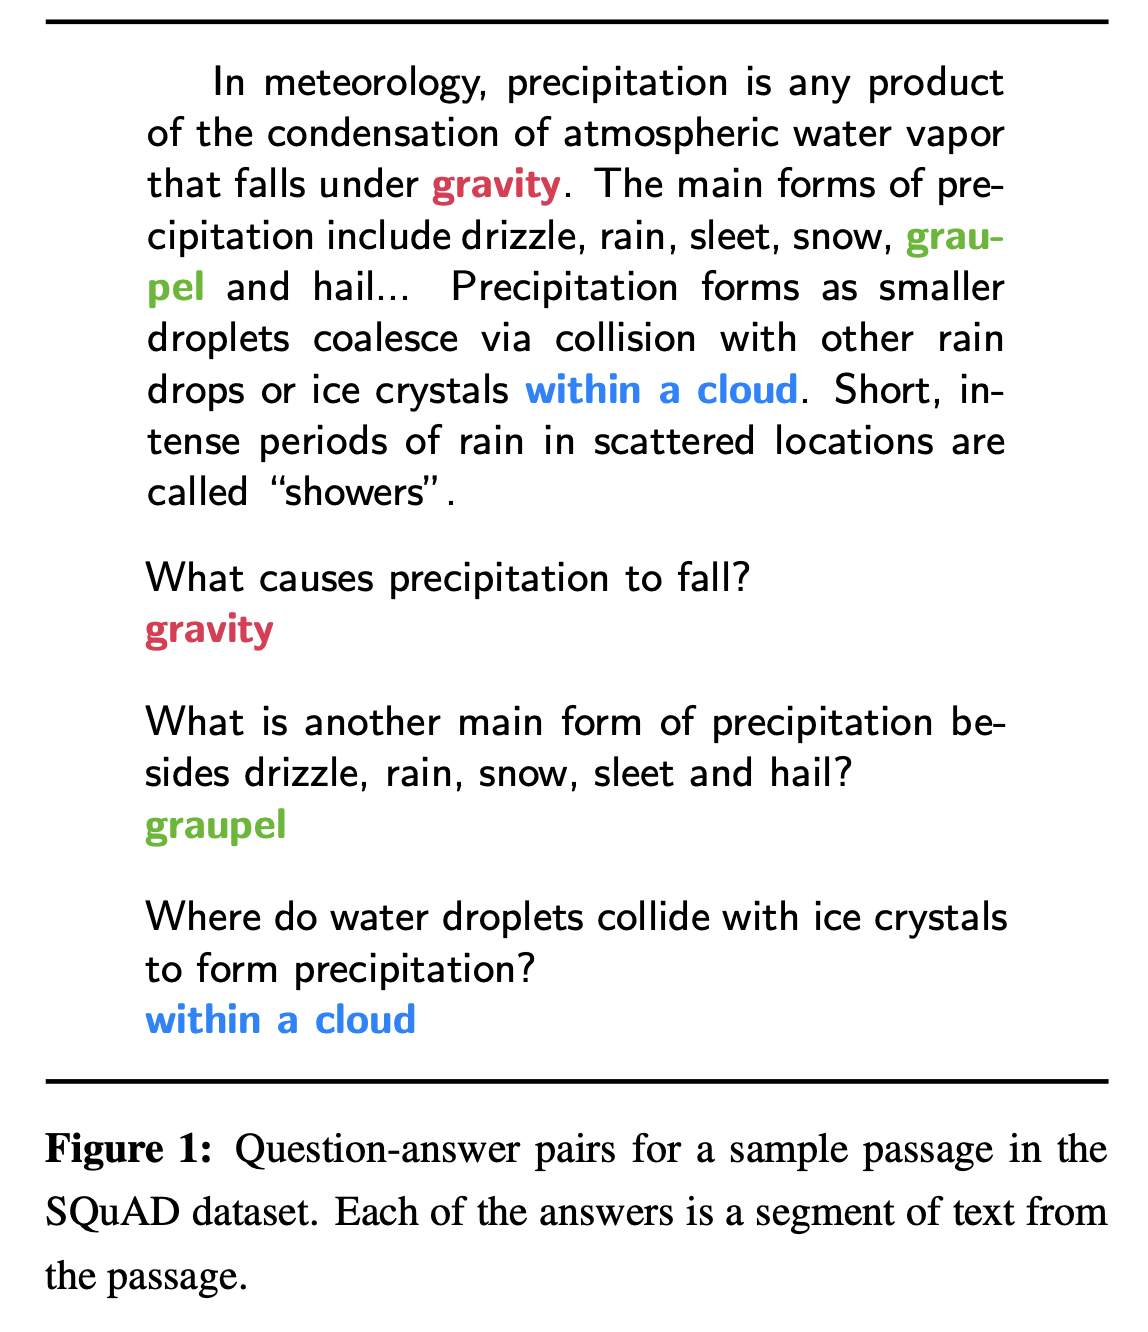

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00


In [2]:

#Lets first import all the libraries we need
!pip install datasets

from transformers import DistilBertTokenizerFast, DistilBertModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import string
import re
from tqdm import tqdm
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
get_device()

'cuda:0'

# Task and dataset

Let's first download the dataset

In [3]:
datasets = load_dataset("squad_v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training and validation. We will split training into training set and the development set and use validation set for testing.

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [5]:
datasets['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [6]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [7]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,5726613a708984140094c421,Freemasonry,"During the ceremony of initiation, the candidate is expected to swear (usually on a volume of sacred text appropriate to his personal religious faith) to fulfil certain obligations as a Mason. In the course of three degrees, new masons will promise to keep the secrets of their degree from lower degrees and outsiders, and to support a fellow Mason in distress (as far as practicality and the law permit). There is instruction as to the duties of a Freemason, but on the whole, Freemasons are left to explore the craft in the manner they find most satisfying. Some will further explore the ritual and symbolism of the craft, others will focus their involvement on the social side of the Lodge, while still others will concentrate on the charitable functions of the lodge.",When does a candidate swear to fullfil his obligations as a Mason?,"{'text': ['During the ceremony of initiation'], 'answer_start': [0]}"
1,5ad5f8a25b96ef001a10af5d,Comprehensive_school,"Finland has used comprehensive schools since the 1970s, in the sense that everyone is expected to complete the nine grades of peruskoulu, from the age 7 to 16. The division to lower comprehensive school (grades 1–6, ala-aste, alakoulu) and upper comprehensive school (grades 7–9, yläaste, yläkoulu) has been discontinued.",What age ranges does Swedish comprehensive school cover?,"{'text': [], 'answer_start': []}"
2,56cd779762d2951400fa65dc,Sino-Tibetan_relations_during_the_Ming_dynasty,"During his travels beginning in 1403, Deshin Shekpa was induced by further exhortations by the Ming court to visit Nanjing by April 10, 1407. Norbu writes that the Yongle Emperor, following the tradition of Mongol emperors and their reverence for the Sakya lamas, showed an enormous amount of deference towards Deshin Shekpa. The Yongle Emperor came out of the palace in Nanjing to greet the Karmapa and did not require him to kowtow like a tributary vassal. According to Karma Thinley, the emperor gave the Karmapa the place of honor at his left, and on a higher throne than his own. Rossabi and others describe a similar arrangement made by Kublai Khan and the Sakya Phagpa lama, writing that Kublai would ""sit on a lower platform than the Tibetan cleric"" when receiving religious instructions from him.",When did Deshin Shekpa travels start?,"{'text': ['1403'], 'answer_start': [32]}"
3,5710dcb5b654c5140001fa11,Age_of_Enlightenment,"Broadly speaking, Enlightenment science greatly valued empiricism and rational thought, and was embedded with the Enlightenment ideal of advancement and progress. The study of science, under the heading of natural philosophy, was divided into physics and a conglomerate grouping of chemistry and natural history, which included anatomy, biology, geology, mineralogy, and zoology. As with most Enlightenment views, the benefits of science were not seen universally; Rousseau criticized the sciences for distancing man from nature and not operating to make people happier. Science during the Enlightenment was dominated by scientific societies and academies, which had largely replaced universities as centres of scientific research and development. Societies and academies were also the backbone of the maturation of the scientific profession. Another important development was the popularization of science among an increasingly literate population. Philosophes introduced the public to many scientific theories, most notably through the Encyclopédie and the popularization of Newtonianism by Voltaire and Émilie du Châtelet. Some historians have marked the 18th century as a drab period in the history of science; however, the century saw significant advancements in the practice of medicine, mathematics, and physics; the development of biological taxonomy; a new understanding of magnetism and electricity; and the maturation of chemistry as a discipline, which established the foundations of modern chemistry.",Voltaire and Emilie d

## TODO 1: Initial Data Observation
Please make at least 5 observations about the training dataset, including but not limtied to total number of articles, total number of unanswerable question, and the average size of answer spans

In [8]:
#TOD0 1
data=datasets['train']
print(f"total number of articles:{len(data)}")
# print(f"total number of unanswerable questions: {data[data['answers']['text']==[]]}")
sum=0
# for x in data['answers']['text']:
#   if len(x)!=0: sum+=len(x)
# sum=sum/len(x)
# print(f"average size of answer spans: {np.sum([len(x) in data['answers']['text'] if x!=0])}")

total number of articles:130319


## TODO 2: Preprocessing Dataset

Fillout the impelementation `read_data` and `add_token_positions`. We will subsample the dataset size for shorter training time

In [9]:
random_sampler = RandomSampler(datasets['train'], num_samples=int(0.3 * len(datasets['train'])))
train_subset = Subset(datasets['train'], list(random_sampler))
random_sampler = RandomSampler(datasets['validation'], num_samples=int(0.3 * len(datasets['validation'])))
test_subset = Subset(datasets['validation'], list(random_sampler))

In [10]:
def read_data(data):
    '''
    This function reads the data and returns the context, question and answer

    Args:
        Data (Dataset): data to be read

        Returns:
            context (list): List of contexts
            question (list): List of questions
            answer (list): List of answers {"text":.., "start_index":.., "end_index":..}, if the question is not answerable, both of them should be 0.
    '''
    context=[]
    question=[]
    answer=[]
    for x in data:
      context.append(x['context'])
      question.append(x['question'])
      text=x['answers']['text']
      if len(text)==0:
        answer.append({"text":'',
                      "start_index":0,
                      "end_index":0}
                      )
      else:
        text=x['answers']['text'][0]
        start=x['answers']['answer_start'][0]
        answer.append({"text":text,
                      "start_index":start,
                      "end_index":start+len(text)}
                      )
    return context,question,answer

In [11]:
train_contexts, train_questions, train_answers = read_data(train_subset)
train_contexts, val_contexts, train_questions, val_questions, train_answers, val_answers = train_test_split(train_contexts, train_questions, train_answers, test_size=0.2)
test_contexts, test_questions, test_answers = read_data(test_subset)

In [12]:
train_answers

[{'text': 'November 1813', 'start_index': 61, 'end_index': 74},
 {'text': 'Metal Gear Solid 4: Guns of the Patriots',
  'start_index': 328,
  'end_index': 368},
 {'text': 'Tim Maudlin', 'start_index': 45, 'end_index': 56},
 {'text': 'Jeffrey Long and Rick Kittles', 'start_index': 0, 'end_index': 29},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': '7 inches', 'start_index': 178, 'end_index': 186},
 {'text': 'Xbox Video Marketplace', 'start_index': 45, 'end_index': 67},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': 'radioactivity', 'start_index': 424, 'end_index': 437},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': '2010', 'start_index': 296, 'end_index': 300},
 {'text': '', 'start_index': 0, 'end_index': 0},
 {'text': 'in vacuo', 'start_index': 619, 'end_in

In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True, return_tensors = 'pt')
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True, return_tensors = 'pt')
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True, return_tensors = 'pt')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
val_encodings['input_ids'][20]

tensor([  101,  1999,  1996,  2220,  3983,  2301,  2195, 17687, 19505,  1006,
         9765, 21041,  4630, 15227,  1007,  2020,  3161,  1999,  5706,  1012,
         2651,  2069,  1037,  2261,  2967,  3961,  1024,  2548,  9765, 21041,
         4630,  3981,  2474, 29485, 18249,  2063,  1006,  2631,  1999,  5692,
         1007,  1999, 14003,  1010,  8782,  7507, 11149, 17687,  2063,  2030,
         9681,  2102,  1999,  8782,  7507,  4017,  1998,  2019,  4032,  1999,
        29408,  1006, 12674,  1007,  1012, 16216, 13639, 11113,  3215,  2003,
         1037,  2092,  2124, 17687,  6819,  5339, 19098,  6499,  1999,  5706,
         1012,  2016,  2003,  2036, 17687,  3836,  1998,  3957,  8220,  1999,
         1996,  2189, 20994,  1997,  4682,  2099,  1010, 15536, 22895, 24746,
         2213,  1998,  8782,  7507,  4017,  1012,  2016,  2003,  2085,  2036,
         2934, 17687,  2012,  1996,  2189,  2152,  2082,  1523, 12849, 11483,
         2243,  3669, 15992,  9530,  8043, 22879, 10050,  2819, 

In [15]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [16]:
def add_token_positions(encodings, answers):
    '''
    This function adds the token positions to the encodings. You have to convert character positions to token positions.
    Hints: You can use encodings.char_to_token method to get the token position and handle the case when the answer is truncated from the context.
    Args:
        encodings (a list of dict): Encodings of context and question
        answers (list): List of answers

    Returns:
        encodings (a list of dict): Encodings of the data with additional dict fields that indicate start token and end positions
    '''
    starts=[]
    ends=[]
    for i in range(len(answers)):
      start=encodings.char_to_token(i,answers[i]['start_index'])
      end=encodings.char_to_token(i,answers[i]['end_index'])
      if start is None:
        start=end=0
      else:
        if end is None:
          end=len(encodings[i].ids)-1
      starts.append(start)
      ends.append(end)
    encodings.update({'start_positions':starts,'end_positions':ends})
    return encodings

In [17]:
train_text = add_token_positions(train_encodings, train_answers)
val_text = add_token_positions(val_encodings, val_answers)
test_text = add_token_positions(test_encodings, test_answers)

In [18]:
class SQUADDataset(Dataset):
    '''
    This class is the dataset class for SQUAD dataset. It return a dictionary with keys of the encodings. Each value in the dictionary is a tensor.
    '''
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [19]:
train_dataset = SQUADDataset(train_encodings)
val_dataset = SQUADDataset(val_encodings)
test_dataset = SQUADDataset(test_encodings)

# Model Implementation

Now, we will implement our model. We will use DistilBERT as our backbome pretrained laungage model for efficiency. DistilBERT is a transformer model with smaller parameters that is distiled from BERT. The simplest way to finetune DistilBERT model on SQUAD2.0 is to first get the contextual representation of context + question and have linear layers on top of the hidden-states output to compute start logits and end logits.

In [20]:
class BERTForQuestionAnswering(nn.Module):
    '''
    This class is the BERT model for question answering. It returns the start and end logits.
    #test one data point
    '''
    def __init__(self):
        super(BERTForQuestionAnswering, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.qa_outputs = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        '''
        params:
          input_ids: Tensor of (Batch Size, Length)
          attention_mask: Tensor of (Batch Size, Length)
        returns:
          start_logits: Tensor of (Batch Size, Length)
          end_logits: Tensor of (Batch Size, Length)
        '''
        outputs=self.bert(input_ids,attention_mask)
        last_hidden_states=outputs.last_hidden_state
        logit_outputs=self.qa_outputs(last_hidden_states)
        start_logits,end_logits=logit_outputs.split(1,dim=-1)
        start_logits=start_logits.squeeze(-1)
        end_logits=end_logits.squeeze(-1)
        return start_logits,end_logits

In [21]:
train_loader = DataLoader(train_dataset, batch_size=8)
temp = next(iter(train_loader))
model = BERTForQuestionAnswering().to(get_device())
model(temp['input_ids'].to(get_device()), temp['attention_mask'].to(get_device()))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

(tensor([[ 0.0127, -0.1045, -0.2797,  ..., -0.1806, -0.2095, -0.2582],
         [ 0.0473, -0.0248, -0.2634,  ..., -0.3308, -0.2006, -0.2724],
         [ 0.1720, -0.1964, -0.2018,  ..., -0.3677, -0.3201, -0.3007],
         ...,
         [ 0.2069, -0.1957, -0.3410,  ..., -0.1899, -0.1669, -0.1860],
         [-0.1615,  0.0221, -0.2815,  ..., -0.3310, -0.3223, -0.3478],
         [ 0.0932, -0.1719, -0.5127,  ..., -0.1973, -0.2578, -0.2375]],
        device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor([[ 0.2062,  0.2110, -0.1825,  ..., -0.2928, -0.4376, -0.3815],
         [ 0.3087,  0.0820, -0.1473,  ..., -0.1832, -0.3551, -0.2694],
         [ 0.3874, -0.1924, -0.3845,  ..., -0.2689, -0.3435, -0.1897],
         ...,
         [ 0.3065, -0.0397, -0.3799,  ..., -0.3074, -0.3388, -0.1644],
         [ 0.1263, -0.1762, -0.3289,  ..., -0.4077, -0.4668, -0.4127],
         [ 0.3012, -0.0450, -0.2444,  ..., -0.0453, -0.4023, -0.2959]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

# Training

After we implement our model, we will use our training data to finetune the model. Specifically, we will use AdamW as our optimization algorithm and CrossEntropy as our loss function. Beside training, we also have to evaluate the model's performance on validation dataset and test dataset. There are two metrics to measure the performance: exact matching (the predicted answer span need to exact as the grouth truth answer span) and f1-score (the overlap between the predicted answer and ground truth answer). One epoch takes about 10-20 mins to run, and 2-3 epoch of training should give you exact match score of 0.5 and f1-score of 0.6. To debug your model implementation, you can see whether your model can overfit a small batch of data points.

In [22]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [23]:
# metric implementation here
def compute_exact(a_gold, a_pred):
    return (get_tokens(a_gold) == get_tokens(a_pred))

def compute_f1(a_gold, a_pred):
    if (a_gold == a_pred == ""):
      return 1
    a_gold = get_tokens(a_gold)
    a_pred = get_tokens(a_pred)
    if (len(a_gold)==0 or len(a_pred)==0):
      # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
      return int(a_gold == a_pred)
    matched = len(list(set(a_gold).intersection(a_pred)))
    p = matched / len(a_pred)
    r = matched / len(a_gold)
    if matched == 0:
      return 0
    f1 = 2 * (p * r) / (p + r)
    return f1

In [24]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    '''
    This function is the training loop of the model. It prints the training loss and validation loss for each epoch.
    '''
    #raise NotImplementedError
    train_loss = 0
    i=0
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(train_loader, leave=False, desc="Training Batches"):
            i+=1
            optimizer.zero_grad()
            input_ids=batch['input_ids'].to(get_device())
            attention_mask=batch['attention_mask'].to(get_device())
            start_positions=batch['start_positions'].to(get_device())
            end_positions=batch['end_positions'].to(get_device())
            start_logits,end_logits=model(input_ids,attention_mask)
            loss=criterion(start_logits,start_positions)+criterion(end_logits,end_positions)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()

        train_loss /= len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')
        exact, f1_score, val_loss = evaluate(model, val_loader,criterion)
        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Exact: {exact}, f1_score: {f1_score}, Validation Loss: {val_loss}')

In [25]:
def train_small(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    '''
    This function is the training loop of the model. It prints the training loss and validation loss for each epoch.
    '''
    #raise NotImplementedError
    train_loss = 0
    i=0
    batch=next(iter(train_loader))
    input_ids=batch['input_ids'].to(get_device())
    attention_mask=batch['attention_mask'].to(get_device())
    start_positions=batch['start_positions'].to(get_device())
    end_positions=batch['end_positions'].to(get_device())

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        start_logits,end_logits=model(input_ids,attention_mask)
        loss=criterion(start_logits,start_positions)+criterion(end_logits,end_positions)
        loss.backward()
        optimizer.step()

        train_loss=loss.item()

        # train_loss /= len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')
        exact, f1_score, val_loss = evaluate_small(model, next(iter(val_loader)),criterion)
        # val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Exact: {exact}, f1_score: {f1_score}, Validation Loss: {val_loss}')

In [26]:
def evaluate(model, val_loader, criterion):
    '''
    This function evaluates the model on the validation set.

    Returns:
      exact_match: a score indicates the accuracy of the model on answering the questions exactly
      f1: the average f1_score of the model on each question
      loss: the total validation loss
    '''
    preds, golds = [], []
    model.eval()
    exact = f1= total = 0
    val_loss = 0
    for batch in tqdm(val_loader, leave=False, desc="Validation Batches"):
        input_ids = batch['input_ids'].to(get_device())
        attention_mask = batch['attention_mask'].to(get_device())
        start_positions = batch['start_positions'].to(get_device())
        end_positions = batch['end_positions'].to(get_device())

        with torch.no_grad():
            start_logits, end_logits = model(input_ids, attention_mask)
        loss=criterion(start_logits,start_positions)+criterion(end_logits,end_positions)
        val_loss+=loss.item()

        # Calculate F1 score for this batch
        for i in range(len(input_ids)):
            start_index = torch.argmax(start_logits[i]).item()
            end_index = torch.argmax(end_logits[i]).item()
            #Your code here. Hints: use tokenizer.convert_ids_to_tokens or tokenizer.decode
            pred = tokenizer.decode(input_ids[i][start_index:end_index+1], skip_special_tokens=True)
            gold = tokenizer.decode(input_ids[i][start_positions[i]:end_positions[i]+1], skip_special_tokens=True)
            exact += compute_exact(gold, pred)
            f1 += compute_f1(gold, pred)
            total += 1
    return exact / total, f1 / total, val_loss

In [27]:
def evaluate_small(model, batch, criterion):
    '''
    This function evaluates the model on the validation set.

    Returns:
      exact_match: a score indicates the accuracy of the model on answering the questions exactly
      f1: the average f1_score of the model on each question
      loss: the total validation loss
    '''
    preds, golds = [], []
    model.eval()
    exact = f1= total = 0
    val_loss = 0
    input_ids = batch['input_ids'].to(get_device())
    attention_mask = batch['attention_mask'].to(get_device())
    start_positions = batch['start_positions'].to(get_device())
    end_positions = batch['end_positions'].to(get_device())

    with torch.no_grad():
        start_logits, end_logits = model(input_ids, attention_mask)

    loss=criterion(start_logits,start_positions)+criterion(end_logits,end_positions)
    val_loss+=loss.item()

    # Calculate F1 score for this batch
    for i in range(len(input_ids)):
        start_index = torch.argmax(start_logits[i]).item()
        end_index = torch.argmax(end_logits[i]).item()
        #Your code here. Hints: use tokenizer.convert_ids_to_tokens or tokenizer.decode
        pred = tokenizer.decode(input_ids[i][start_index:end_index+1], skip_special_tokens=True)
        gold = tokenizer.decode(input_ids[i][start_positions[i]:end_positions[i]+1], skip_special_tokens=True)
        exact += compute_exact(gold, pred)
        f1 += compute_f1(gold, pred)
        total += 1
    return exact / total, f1 / total, val_loss

In [28]:
train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
model = BERTForQuestionAnswering().to(get_device())
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-5)
train(model, train_loader, val_loader, loss_fn, optimizer, 3)
# train_small(model, train_loader, val_loader, loss_fn, optimizer, 30)

Epoch 1/3, Training Loss: 3.4489591077465533


Epoch 1/3, Exact: 0.43202455556976593, f1_score: 0.496737297771654, Validation Loss: 2.5350955462041322


Epoch 2/3, Training Loss: 2.0693597776951664


Epoch 2/3, Exact: 0.4989129044634864, f1_score: 0.5509644766694681, Validation Loss: 2.495012955553449


Epoch 3/3, Training Loss: 1.300795836731976


Epoch 3/3, Exact: 0.4934134799846528, f1_score: 0.5508418582299786, Validation Loss: 3.0492568502092166


In [29]:
evaluate(model, test_loader, loss_fn)

(0.4085930918281382, 0.4567283412183903, 1684.0527698993683)